# Chapter 10

#### Load Libraries

In [ ]:
library(MASS)

## be careful to load dplyr after MASS
library(dplyr)
library(tidyr)
library(purrr)
library(extraDistr)
library(ggplot2)
library(loo)
library(bridgesampling)
library(brms)
library(bayesplot)
library(tictoc)
library(hypr)
library(bcogsci)
library(lme4)
library(rstan)
# library(cmdstanr)
library(rootSolve)

In [7]:
## Save compiled models:
rstan_options(auto_write = FALSE)
## Parallelize the chains using all the cores:
options(mc.cores = parallel::detectCores())
# To solve some conflicts between packages
select <- dplyr::select
extract <- rstan::extract

## Normal model

In [2]:
# define data

Y <- rnorm(n = 100, mean = 3, sd = 10)

In [ ]:
# create data for stan
lst_score_data <- list(y = Y, N = length(Y))

# Fit the model with the default values of number of
# chains and iterations: chains = 4, iter = 2000
fit_score <- stan("stan_models/normal.stan", data = lst_score_data)

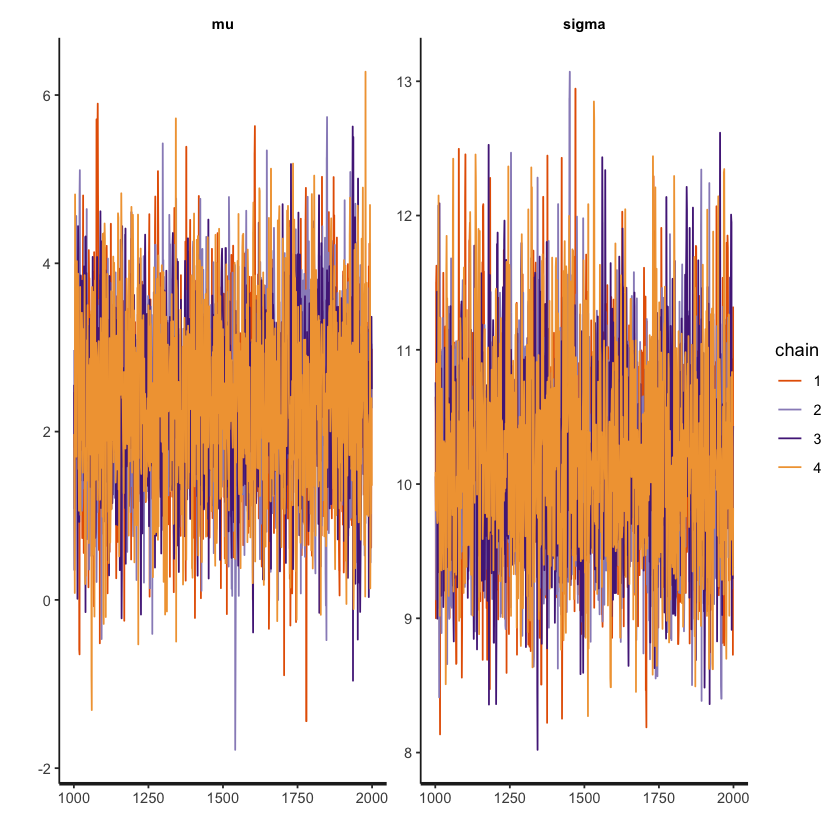

In [8]:
traceplot(fit_score, pars = c("mu", "sigma"))

In [9]:
print(fit_score, pars = c("mu", "sigma"))

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean   sd 2.5%  25%   50%   75% 97.5% n_eff Rhat
mu     2.37    0.02 1.04 0.33 1.65  2.37  3.06  4.41  3128    1
sigma 10.19    0.01 0.73 8.87 9.67 10.16 10.64 11.71  2705    1

Samples were drawn using NUTS(diag_e) at Sat Sep 10 11:25:06 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


ci_level: 0.8 (80% intervals)

outer_level: 0.95 (95% intervals)



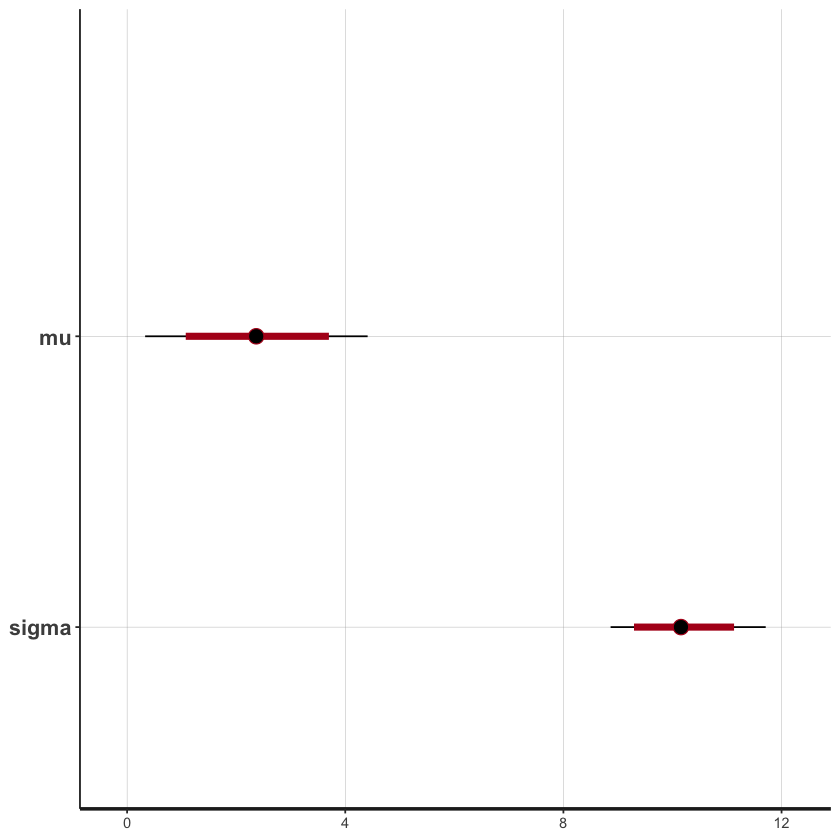

In [10]:
plot(fit_score)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



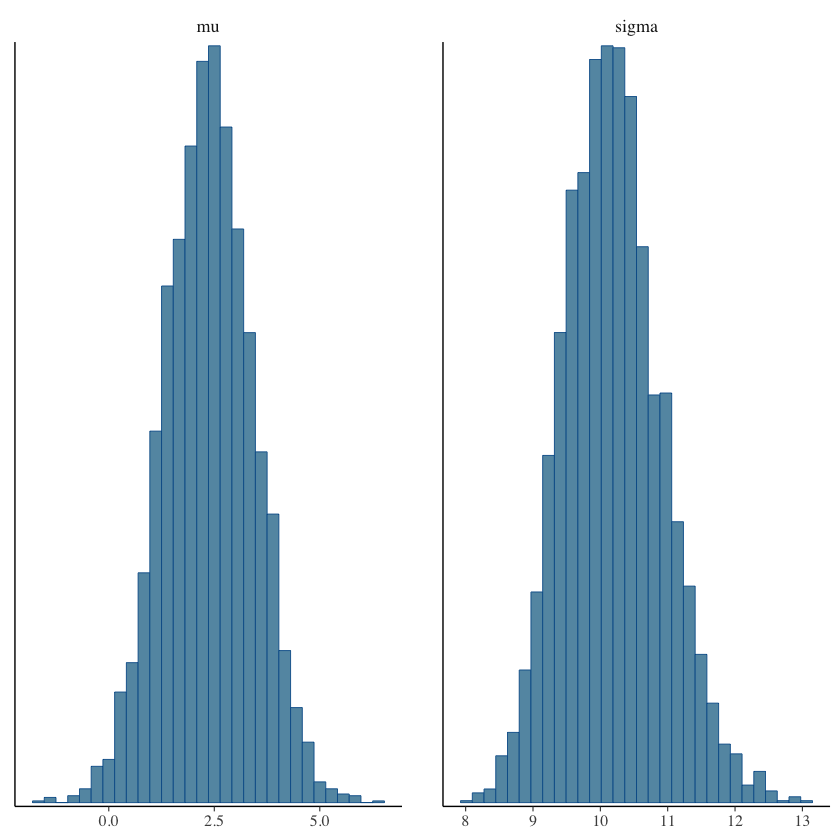

In [11]:
df_fit_score <- as.data.frame(fit_score)
mcmc_hist(df_fit_score, pars = c("mu", "sigma"))

## Binomial model

In [12]:
# define data
lst_cloze_data <- list(k = 80, N = 100)

In [ ]:
fit_cloze <- stan("stan_models/binomial_cloze.stan", data = lst_cloze_data)

In [14]:
print(fit_cloze, pars = c("theta"))

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

      mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
theta 0.78       0 0.04 0.69 0.75 0.78 0.81  0.85  1464    1

Samples were drawn using NUTS(diag_e) at Sat Sep 10 11:46:29 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


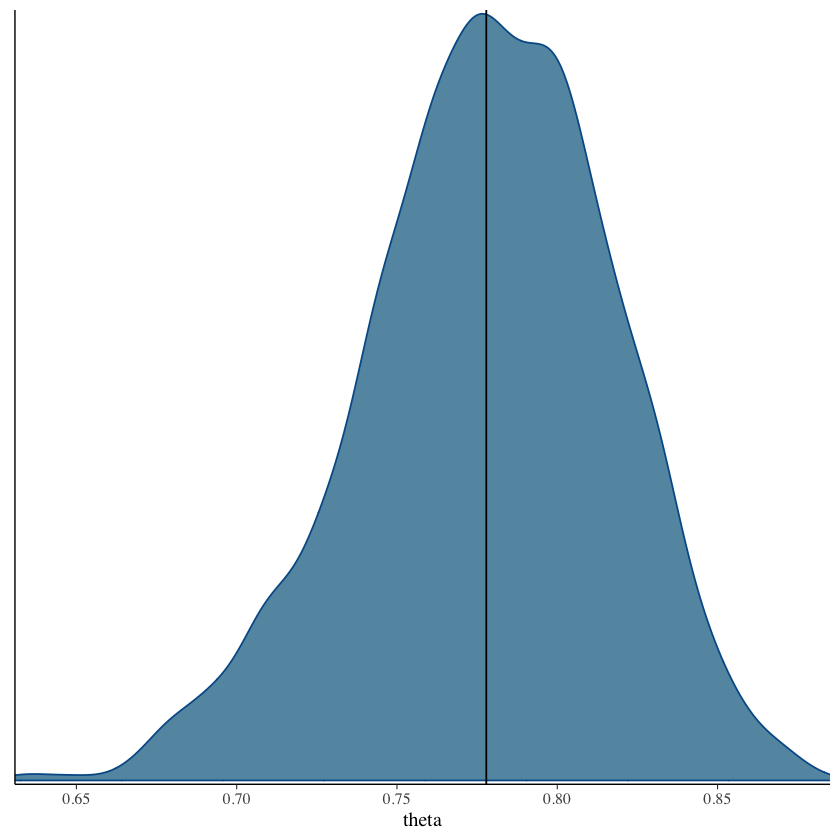

In [15]:
df_fit_cloze <- as.data.frame(fit_cloze)

mcmc_dens(df_fit_cloze, pars = "theta") +
  geom_vline(xintercept = mean(df_fit_cloze$theta))

## Regression model

In [4]:
# load data
data("df_pupil")

# center parameter load
df_pupil <- df_pupil %>%
  mutate(c_load = load - mean(load))

In [ ]:
# data for stan model
ls_pupil <- list(
  p_size = df_pupil$p_size,
  c_load = df_pupil$c_load,
  N = nrow(df_pupil)
) 

fit_pupil <- stan("stan_models/pupil_model.stan", data = ls_pupil)

In [8]:
print(fit_pupil, pars = c("alpha", "beta", "sigma"))

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean    sd   2.5%    25%    50%    75%  97.5% n_eff Rhat
alpha 701.08    0.31 19.48 663.11 688.06 700.94 714.06 740.02  3895    1
beta   33.86    0.19 11.75  11.10  26.12  33.75  41.58  57.38  3639    1
sigma 128.36    0.28 15.24 102.08 117.78 127.00 138.04 161.08  2932    1

Samples were drawn using NUTS(diag_e) at Sat Sep 10 12:13:12 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



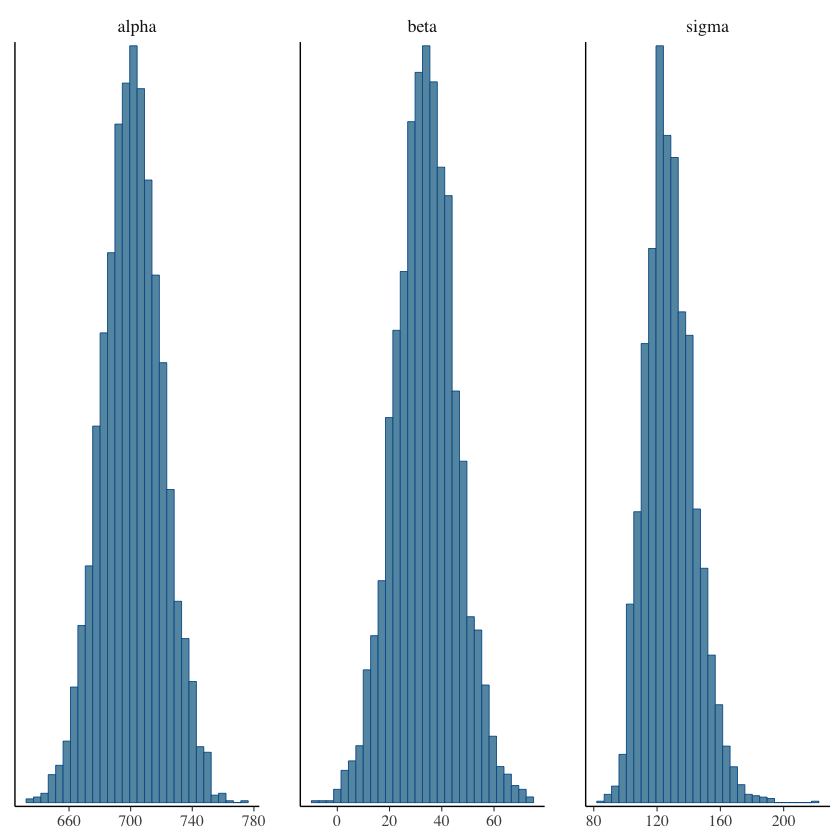

In [9]:
df_fit_score <- as.data.frame(fit_pupil)
mcmc_hist(df_fit_score, pars = c("alpha", "beta", "sigma"))

#### Posterior predictive checks

In [10]:
ls_pupil <- list(
  onlyprior = 0,
  p_size = df_pupil$p_size,
  c_load = df_pupil$c_load,
  N = nrow(df_pupil)
)

fit_pupil <- stan("stan_models/pupil_model_gen.stan", data = ls_pupil)

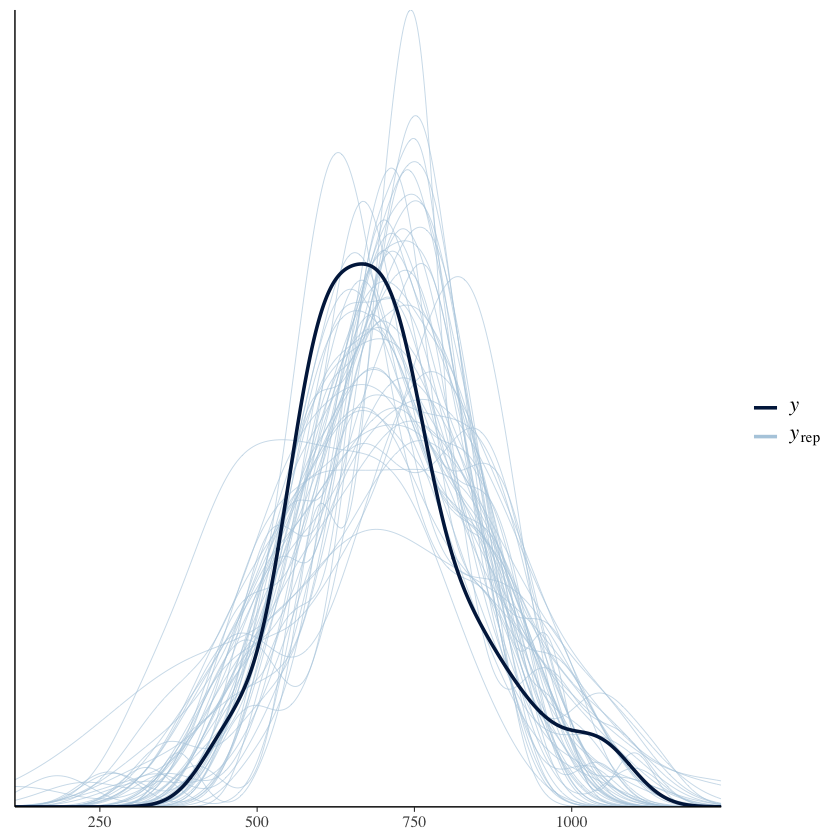

In [11]:
yrep_pupil <- extract(fit_pupil)$p_size_pred

ppc_dens_overlay(df_pupil$p_size, yrep = yrep_pupil[1:50, ])

#### Prior predictive checks

In [14]:
ls_pupil <- list(
  onlyprior = 1,
  p_size = df_pupil$p_size,
  c_load = df_pupil$c_load,
  N = nrow(df_pupil)
)

fit_pupil <- stan("stan_models/pupil_model_gen.stan", data = ls_pupil)

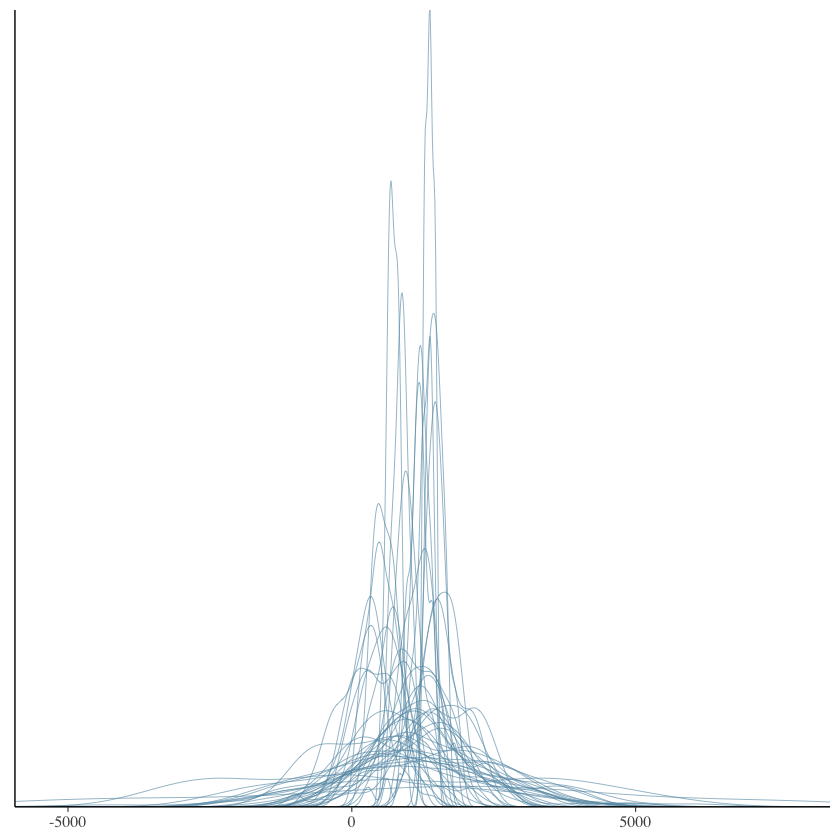

In [18]:
yrep_prior_pupil <- extract(fit_pupil)$p_size_pred

ppd_dens_overlay(yrep_prior_pupil[1:50, ])

## Regression with interactions

In [19]:
# center variables
df_pupil <- df_pupil %>%
  mutate(
    c_trial = trial - mean(trial),
    c_load = load - mean(load)
  )

In [28]:
# create model matrix with independent variables and interaction
X <- model.matrix(~ 0 + c_load*c_trial, df_pupil)
head(X)

,c_load,c_trial,c_load:c_trial
1,-0.4390244,-20,8.780488
2,-1.4390244,-19,27.341463
3,2.5609756,-18,-46.097561
4,1.5609756,-17,-26.536585
5,-2.4390244,-16,39.024390
6,0.5609756,-15,-8.414634


In [29]:
# define data for mode
ls_pupil_X <- list(
  p_size = df_pupil$p_size,
  X = X,
  K = ncol(X),
  N = nrow(df_pupil)
)

In [30]:
fit_pupil_int <- stan("stan_models/pupil_model_inter_complex.stan", data = ls_pupil_X)

In [31]:
print(fit_pupil_int, pars = c("alpha", "beta", "sigma"))

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean    sd   2.5%    25%    50%    75%  97.5% n_eff Rhat
alpha   699.33    0.23 16.71 665.81 688.76 699.51 710.43 732.58  5302    1
beta[1]  31.63    0.13  9.58  13.60  25.17  31.56  38.01  50.59  5526    1
beta[2]  -5.79    0.02  1.36  -8.46  -6.69  -5.79  -4.89  -3.12  4788    1
beta[3]  -1.82    0.01  0.82  -3.41  -2.38  -1.83  -1.27  -0.25  5530    1
sigma   104.05    0.19 12.75  82.77  95.09 102.96 111.65 131.77  4453    1

Samples were drawn using NUTS(diag_e) at Sat Sep 10 12:51:43 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



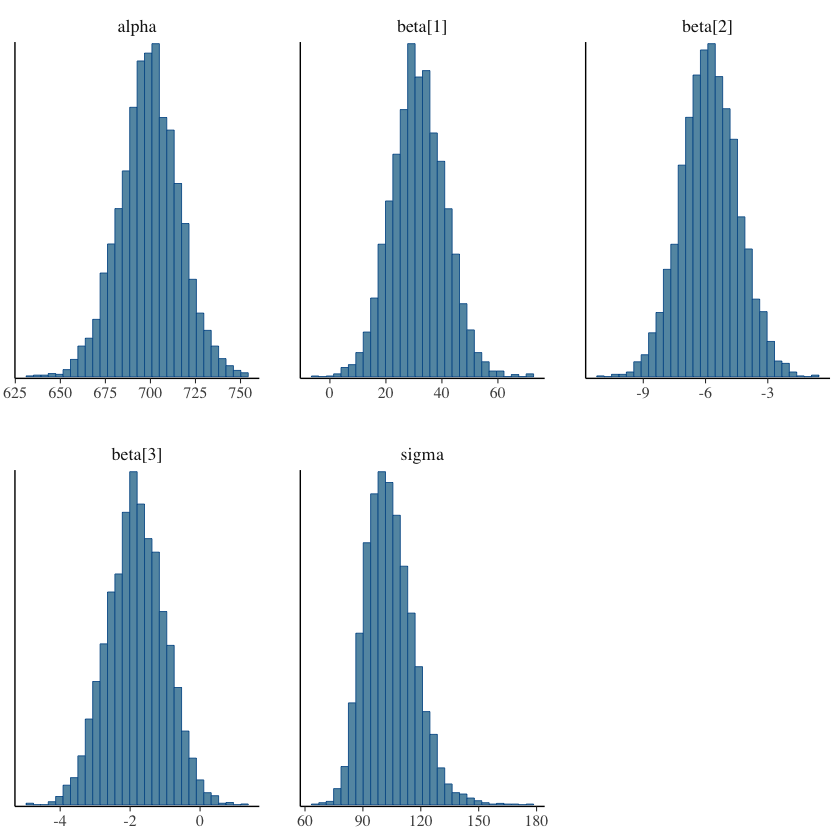

In [35]:
# cast to df
df_fit_pupil_int <- as.data.frame(fit_pupil_int)

mcmc_hist(df_fit_pupil_int[1:5])

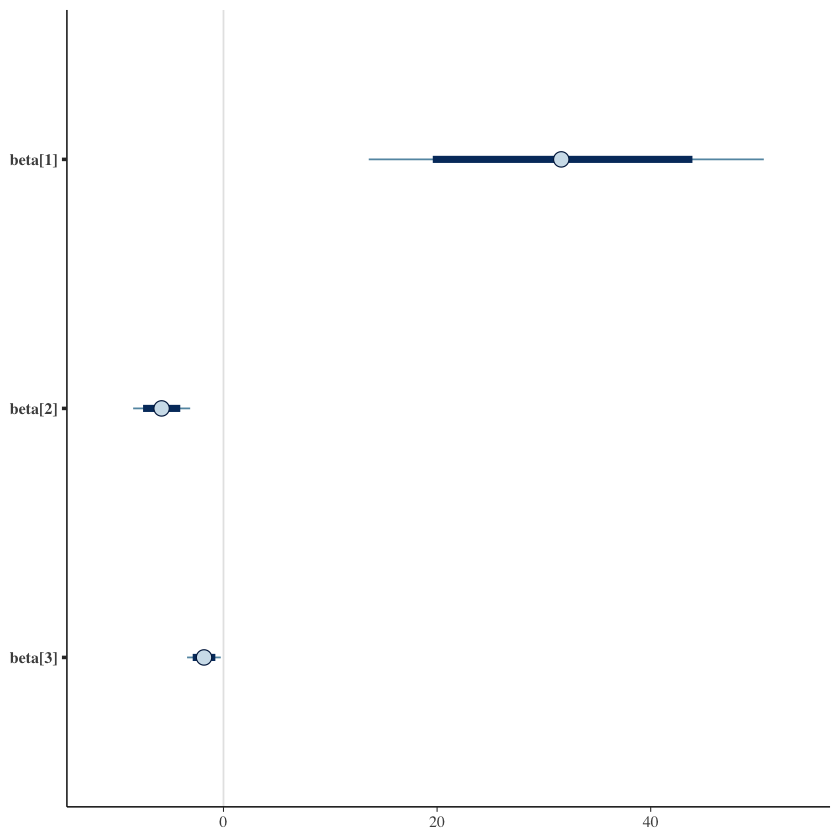

In [36]:
mcmc_intervals(fit_pupil_int,
  regex_pars = "beta",
  prob_outer = .95,
  prob = .8,
  point_est = "mean"
)